In [139]:
# Importing necessary libraries

import os
import cv2
import cv2 as cv
import PIL
import math 
import zipfile
import random
import numpy as np
import pandas as pd
import tkinter as tk
from PIL import Image, ImageTk
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

## Data Model
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GaussianNoise, Dropout, Flatten, Dense, LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
#import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
#import torch.nn as nn

In [ ]:
!pip install kaggle

In [3]:
import shutil

# Define paths
src = "E:/Iris Detection Model/Iris Model/kaggle (1).json"  # Your actual path
dst_dir = os.path.expanduser("~/.kaggle")
dst = os.path.join(dst_dir, "kaggle.json")

# Create .kaggle folder if it doesn't exist
os.makedirs(dst_dir, exist_ok=True)

# Copy the file
shutil.copy(src, dst)

# Secure the permissions (optional but recommended)
os.chmod(dst, 0o600)

print("Kaggle API token set up successfully.")

Kaggle API token set up successfully.


Displaying: E:\Iris Detection Model\Iris Model\CASIA-Iris-Thousand\CASIA-Iris-Thousand\000\L\S5000L00.jpg


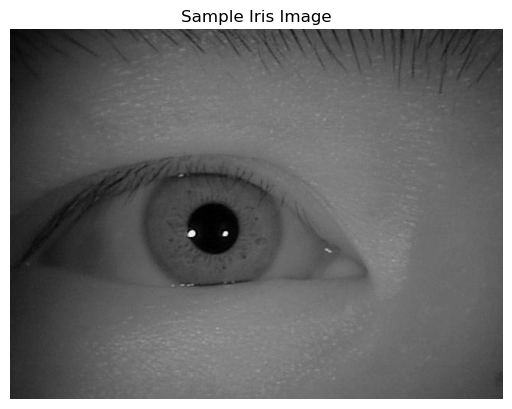

In [5]:
#import os
from PIL import Image
#import matplotlib.pyplot as plt

# Path to the main dataset folder
image_folder = r"E:\Iris Detection Model\Iris Model\CASIA-Iris-Thousand\CASIA-Iris-Thousand"

# Recursively find the first image file
image_path = None
for root, dirs, files in os.walk(image_folder):
    for file in files:
        if file.lower().endswith((".jpg", ".png", ".bmp")):
            image_path = os.path.join(root, file)
            break
    if image_path:
        break

# Display the image
if image_path:
    print(f"Displaying: {image_path}")
    img = Image.open(image_path)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Sample Iris Image")
    plt.show()
else:
    print("No image file found.")


In [7]:
## configuration

image_size = (224, 224)
data_folder =  r"E:\Iris Detection Model\Iris Model\CASIA-Iris-Thousand\CASIA-Iris-Thousand"
#num = 10

In [9]:
def load_images(image_size, data_folder, max_images=None):
    images = []
    labels = []
    count = 0

    for label in os.listdir(data_folder):
        label_folder = os.path.join(data_folder, label)
        if os.path.isdir(label_folder):
            # Go one more level deep for subfolders (e.g., 'L', 'R')
            for subfolder in os.listdir(label_folder):
                subfolder_path = os.path.join(label_folder, subfolder)
                if os.path.isdir(subfolder_path):
                    for fname in os.listdir(subfolder_path):
                        if fname.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp')):
                            fpath = os.path.join(subfolder_path, fname)
                            try:
                                img = Image.open(fpath).resize(image_size).convert('RGB')
                                images.append(np.array(img))
                                labels.append(label)  # Label as folder name like '000', '001'
                                count += 1
                                if max_images is not None and count >= max_images:
                                    return np.array(images, dtype=np.float32) / 255.0, labels
                            except Exception as e:
                                print(f"Failed to load {fpath}: {e}")

    return np.array(images, dtype=np.float32) / 255.0, labels


In [13]:
image_size = (224, 224)
data_folder = r"E:\Iris Detection Model\Iris Model\CASIA-Iris-Thousand\CASIA-Iris-Thousand"
max_images = 100
#X, y, label_encoder, images, labels = load_images(image_size, data_folder)
X, labels = load_images(image_size, data_folder, max_images=max_images)
print(f"Loaded {len(X)} images.")

# Plot random 9 samples
num = 9
random.seed(1190652)
#random_indices = random.sample(range(len(images)), min(num, len(images)))

Loaded 100 images.


In [15]:
def show_random_samples(X, labels, num):
    random_indices = random.sample(range(len(X)), min(num, len(X)))

    plt.figure(figsize=(20,20))
    for i, index in enumerate(random_indices):
        plt.subplot(3, 3, i+1)
        plt.imshow(X[index])
        plt.title(f'Image of a {labels[index]}  Person Label')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

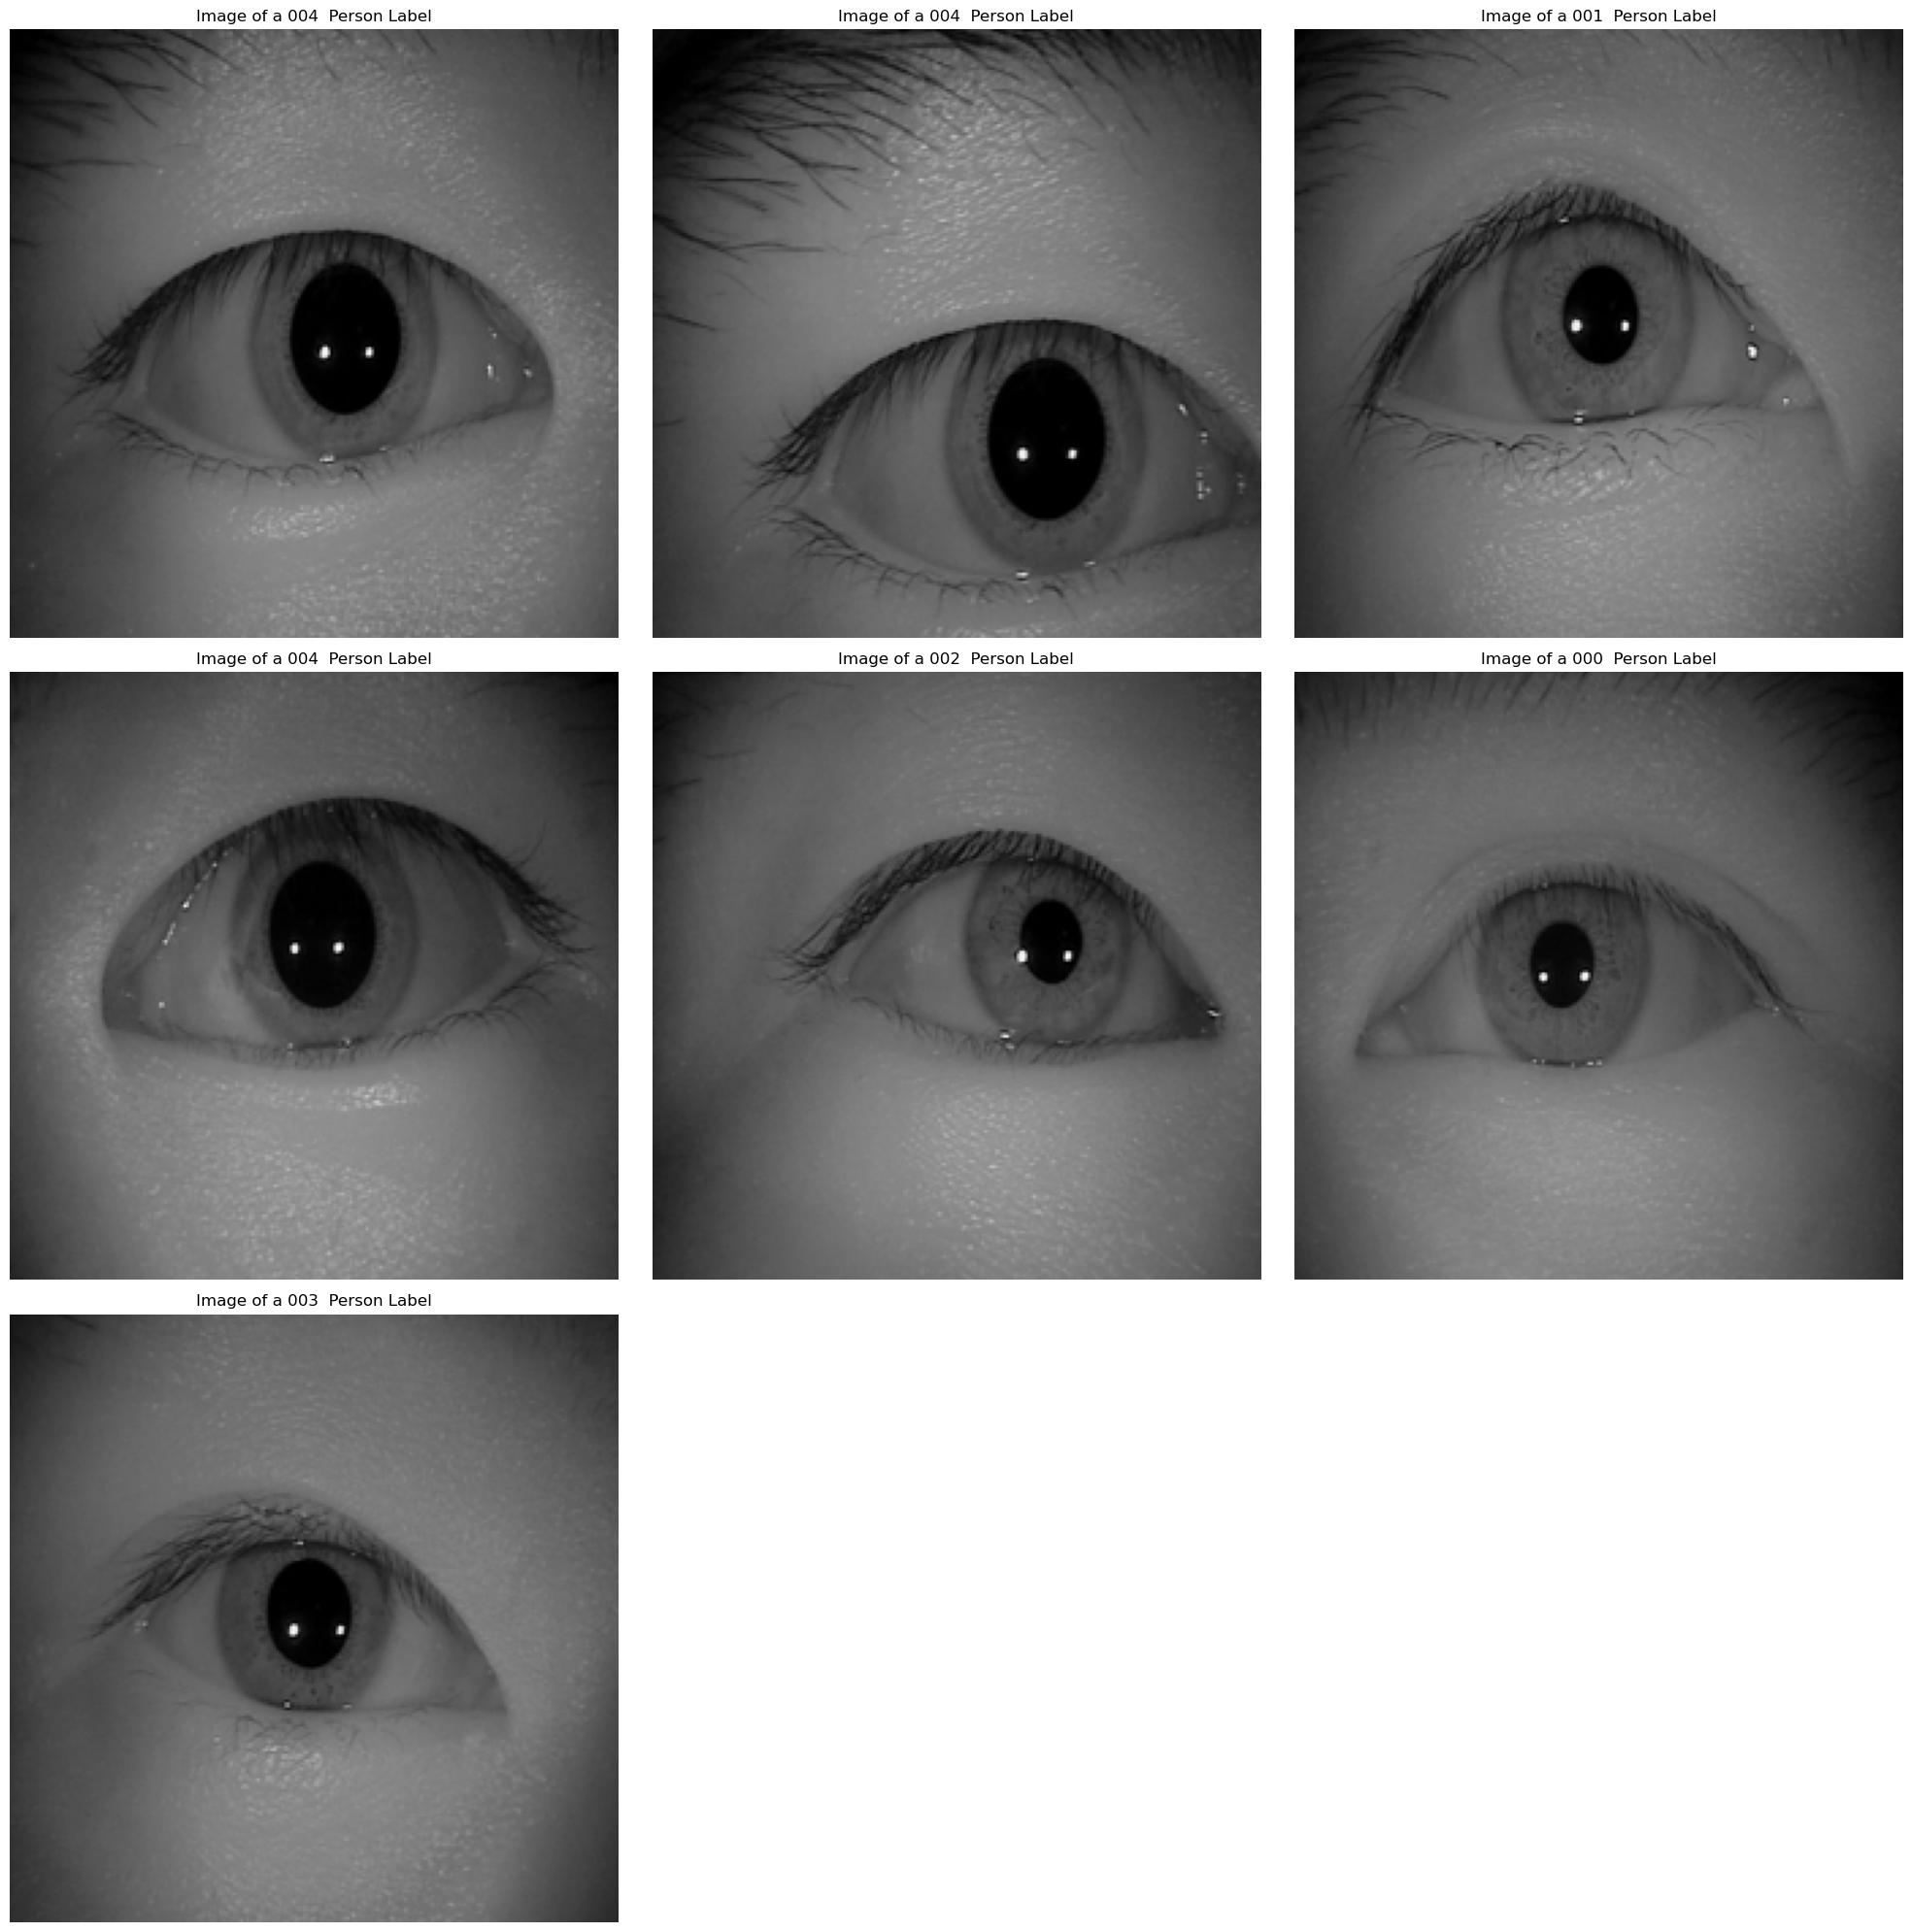

In [17]:
show_random_samples(X, labels, 7)

In [19]:
## Setting the image width's and height's

num, height, width, channels = X.shape
print(f'Number of images: {num}')
print(f'The width of the image is {width}')
print(f'The height of the image is: {height}')

Number of images: 100
The width of the image is 224
The height of the image is: 224


> Some eye samples are from right while some are right.
> It is to be noted that :- 
* Eyes wearing glasses
* Some uses eyeliner
* some eye pupils are big
* Some eye pupils are small and,
* The iris images are grayscaled

### Rescaling and Resizing a Single Iris Image 

In [21]:
##data_folder = r"E:\Iris Detection Model\Iris Model\CASIA-Iris-Thousand"
#img_name = 'S5000R00.jpg'
#path_name = os.path.join(img_folder, img_name)

#img = cv.imread(path_name)

## Check that if the image has been detected or not...
#if img is not None:

#    cv.imshow('Sample Iris Image - S5000R00', img)
 #   cv.waitKey(0)
  #  cv.destroyAllWindows()
#else:
 #   print('No image Detected')
    
## Rescaling image size

def rescaling(frame, scale=0.6):
    width = int(frame.shape[1] * scale)
    height = int(frame.shape[0] * scale)
    dimensions = (width,height)
    print(f'The Dimension of the image is: {dimensions}')

    return cv.resize(frame, dimensions, interpolation=cv.INTER_AREA)

## Getting the first image...
img_path = None
for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.lower().endswith(('.jpg')):
            img_path = os.path.join(root, file)
            break
    if img_path:
        break


##rescale

#if img_path:
 #   print(f'Loaded_Image: {img_path}')
  #  cv.imshow('The Original Iris Image: \n', img)
   # img = cv.imread(img_path)

    ## Rescaled image...
    #recaled_image = rescaling(img, 0.2) 
    #cv.imshow('Rescaled Iris Image: \n', rescaled_image)
    #cv.waitKey(0)
    #cv.destroyAllWindows()
#else:
 #   print('No images were loaded')
    
if img_path:
    print(f"Loaded: {img_path}")
    img = cv.imread(img_path)
    cv.imshow('Original Iris Image', img)
    resized_img = rescaling(img, scale=0.6)
    cv.imshow('Rescaled Iris Image', resized_img)

    cv.waitKey(0)
    cv.destroyAllWindows()
else:
    print("No image found in the dataset folder!")
#cv.waitkey(0)

Loaded: E:\Iris Detection Model\Iris Model\CASIA-Iris-Thousand\CASIA-Iris-Thousand\000\L\S5000L00.jpg
The Dimension of the image is: (384, 288)


In [23]:
## Loading multiple images

images = []
for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.lower().endswith(( '.jpg')):
            images.append(os.path.join(root, file))
            
## Taking number of sample images
num_img = 5
random_sample_iris_images = random.sample(images, num_img)

for img_path in random_sample_iris_images:
    img = cv.imread(img_path)

    if img is not None:
        cv.imshow('Original Iris Image', img)
        cv.imshow('Rescaled Iris Image', resized_img)

        key=cv.waitKey(0) & 0xFF==ord('d')
        if key==27:
            break

cv.destroyAllWindows()

In [25]:
num_img = 15  
cols = 5       
img_size = (224, 224) 

for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.lower().endswith(".jpg"):
            images.append(os.path.join(root, file))

#if not images:
 #   raise FileNotFoundError("No JPG images found in the given folder.")


random_sample_iris_images = random.sample(images, min(num_img, len(images)))


window = tk.Tk()
window.geometry("1200x800")
window.title("Displaying Grid Images of an Iris")

# This list will hold all PhotoImage references
image_refs = []
row = 0
col = 0
for img_path in random_sample_iris_images:
    try:
        img = Image.open(img_path)
        img = img.resize(img_size, Image.Resampling.LANCZOS)

        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img_tk = ImageTk.PhotoImage(img)

        image_refs.append(img_tk)
        label = tk.Label(window, image=img_tk, relief="raised", borderwidth=2)
        label.image = img_tk
        label.grid(row=row, column=col, padx=5, pady=5)

        # Positioning logic
        col += 1
        if col >= cols:
            col = 0
            row += 1

    except Exception as e:
        print(f"Error loading {img_path}: {e}")

window.mainloop()

### Data Distribution of Images and Lables

>> Calculate labels and aspect ratios

In [27]:
images = []
aspect_ratios = []

for img_path in random_sample_iris_images:
    img = PIL.Image.open(img_path)
    width, height=img.size
    images.append(width*height)
    #images.append(width/height)

Text(0, 0.5, 'Number of Frequencies')

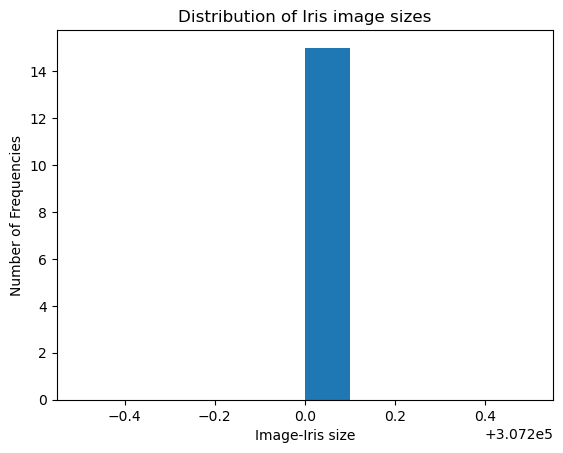

In [29]:
plt.hist(images, label='Image-Iris Size')
plt.title('Distribution of Iris image sizes')
plt.xlabel('Image-Iris size')
plt.ylabel('Number of Frequencies')

### Plotting a Hostogram

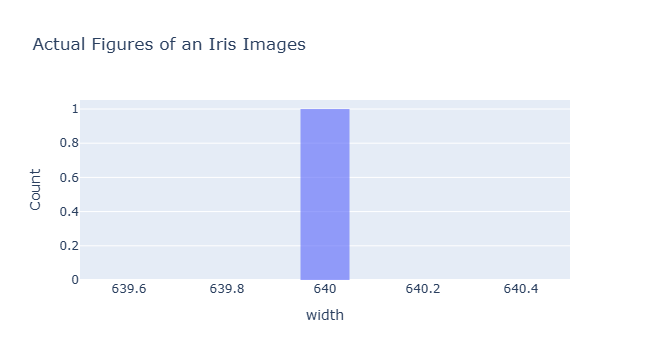

In [31]:
## take width and height
width = []
#Heights = []

img = Image.open(img_path)
w,h=img.size
width.append(w)
#Heights.append(h)

#for root, dirs, files in os.walk(data_folder):
    #for file in files:
    #    if file.lower().endswith(".jpg"):
   #         img_path = os.path.join(root, file)
   #         images.append(os.path.join(root, file))

fig = px.histogram(x=width, title = 'Actual Figures of an Iris Images',
                   labels={'x': 'width'},opacity=0.65)
#fiimage_widths = 
#image_sizes = go.Scatter(mode='lines',line=dict(color='black'))
#fig.add_trace(go.Scatter(min[Widhts], max[Widths]

## Adding a trace to the histplot
fig.update_layout(
    xaxis_title='width',
    yaxis_title='Count',
   # title='Actual Figures of an Iris Images',
    bargap=0.9
)
fig.show()

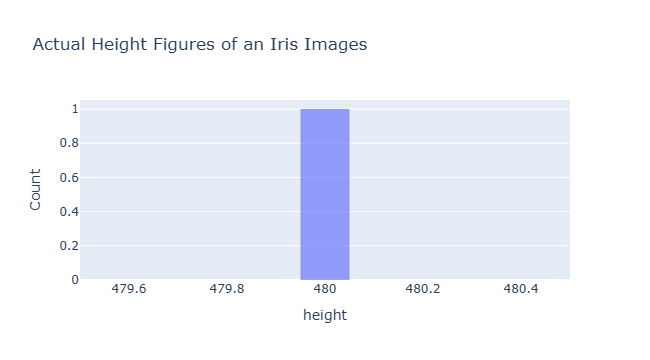

In [33]:
### Plotting for 'Height'

height = []
height.append(h)

fig = px.histogram(x=height, title = 'Actual Height Figures of an Iris Images',
                   labels={'y': 'Height'},opacity=0.65)

## Adding a trace to the histplot
fig.update_layout(
    xaxis_title='height',
    yaxis_title='Count',
   # title='Actual Figures of an Iris Images',
    bargap=0.9
)
fig.show()

#### Image Preprocessing

In [35]:
images = []

for root, dirs,files in os.walk(data_folder):
    for file in files:
        if file.lower().endswith(".jpg"):
            img_path = os.path.join(root, file)
            #images.append(os.path.join(root, file))
            #img = cv2.imread(img_path)
            #if img is not None:
             #   images.append(img)
        try:
            with Image.open(img_path) as img:
                height.append(img.height)
        except Exception as e:
            print('Error loading', e)

print(f"Found {len(height)} images")
print("First 10 heights:", height[:10])

Found 20013 images
First 10 heights: [480, 480, 480, 480, 480, 480, 480, 480, 480, 480]


In [37]:
height, widths, aspect_ratio, formats, file_sizes = [], [], [], [], []

for root, dirs,files in os.walk(data_folder):
    for file in files:
        if file.lower().endswith(".jpg"):
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    width.append(img.width)
                    height.append(img.height)
                    aspect_ratio.append(round(img.width / img.height, 2))
                    formats.append(img.format)
                file_sizes.append(os.path.getsize(img_path) / 1024)
            except:
                pass

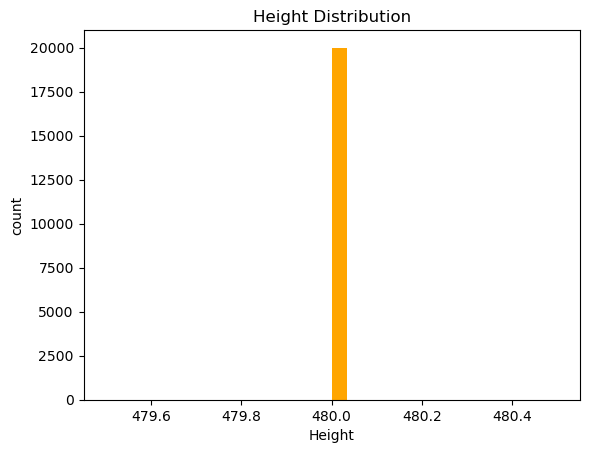

In [39]:
## Height Distribution

plt.hist(height, bins=30, color='orange')
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('count')
plt.show()

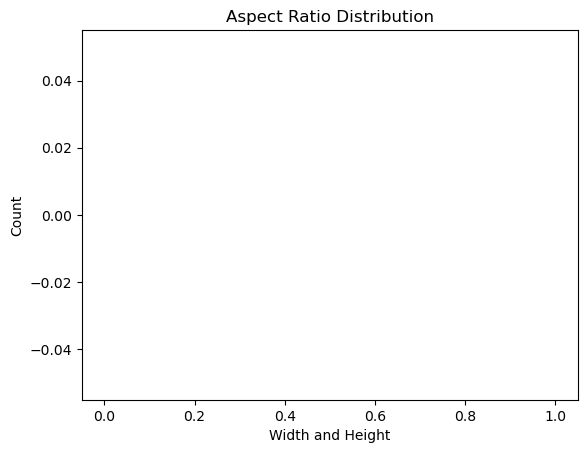

In [41]:
## Aspect Ratios distribution
plt.hist(aspect_ratios, bins=30, color='green')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Width and Height')
plt.ylabel('Count')
plt.show()

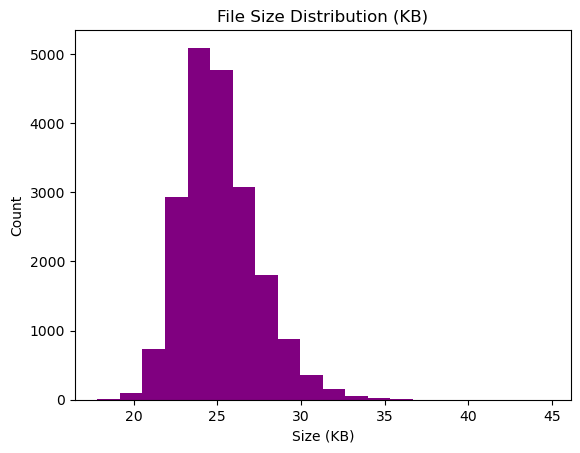

In [43]:
## File size distribution

plt.hist(file_sizes, bins=20, color='purple')
plt.title("File Size Distribution (KB)")
plt.xlabel("Size (KB)")
plt.ylabel("Count")
plt.show()

In [45]:
def image_preprocessing(images):
    '''
    img_path - image path on the CASIA-Iris-Thousand folder
    Height - Height of a Image
    Width = Width of the Image
    Next steps:- Preprocessing of a risized image
    '''

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = img/255.
    return img

d


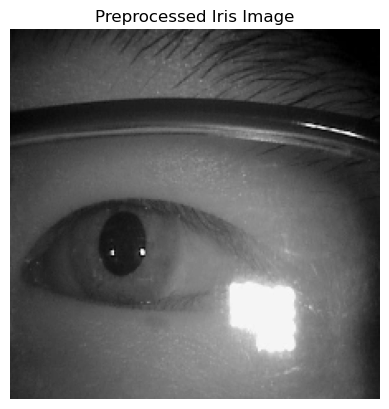

In [47]:
## Check the preprocess image
sample_path = img_path[20] 
#img = Image.open(img_path)
print(sample_path)
processed_img = image_preprocessing(sample_path)
plt.imshow(processed_img, cmap='gray')
plt.title('Preprocessed Iris Image')
plt.axis('off')
plt.show()

### Labels processing

> As there is no missing values so, not much training is required

In [49]:
def preprocessing_labels(images):
    images = []
    labels = []

    label_path = os.path.join(root, file)
    img_paths.append(label_path)

    ## Extracting folder 

    label = os.path.basename(root)
    labels.append(label)

In [51]:
## See the total number of images as well as lables

print(f'Total number of images: {len(img_path)}')
print(f'Total number of labels: {len(set(labels))}')

Total number of images: 93
Total number of labels: 5


In [53]:
## Encode labels

le = LabelEncoder()
label_encoder = le.fit_transform(labels)
#return label_encoder

In [55]:
le

LabelEncoder()

### STrain-Test split

In [ ]:
## In this we'll split the image data into 80:10:10 rule

In [55]:
processed_images = []
processed_labels = []
for path, label in zip(img_path, labels):
    try:
        img = image_preprocessing(path)
        processed_images.append(img)
        processed_labels.append(label)
    except Exception as e:
        print(e)

processed_images = np.array(processed_images, dtype=np.float32)
processed_labels = np.array(processed_labels)

print(f"Processed images shape: {processed_images.shape}")
print(f"Labels shape: {processed_labels.shape}")

Processed images shape: (93, 224, 224)
Labels shape: (93,)


In [ ]:
### data split function using 80:20:10:10
## Split the first one:- train(80%) and temp(20%)

In [57]:
x_train, x_temp, y_train, y_temp = train_test_split(
    processed_images, processed_labels,
    test_size=0.20,
    stratify=processed_labels,
    random_state=42
)

In [59]:
## split the secind one : Validation 10% and 10% testing

x_val,x_test,y_val,y_test = train_test_split(
    x_temp,y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

In [ ]:
### We'll print and find out all the train, validation as well as test shapes

In [61]:
print(f'Training set: {x_train.shape}, {y_train.shape}')
print(f'Testing set: {x_test.shape}, {y_test.shape}')
print(f'Validation set: {x_val.shape}, {y_val.shape}')

Training set: (74, 224, 224), (74,)
Testing set: (10, 224, 224), (10,)
Validation set: (9, 224, 224), (9,)


### Data Augmentation

We'll try and test with running a sample Iris image on augmented data

In [65]:
#img = tf.convert_to_tensor(img, dtype=tf.float32)
#img = tf.expand_dims(img, axis=-1)
#cropped_image = tf.image.central_crop(img, central_fraction=0.5)
#print(img, cropped_image)

In [63]:
img = tf.expand_dims(processed_images, axis=-1)
cropped_images = tf.image.central_crop(img, central_fraction=0.5)
print(img, cropped_images)

tf.Tensor(
[[[[0.03137255]
   [0.03529412]
   [0.03137255]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.04705882]
   [0.04313726]
   [0.04313726]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.05098039]
   [0.03529412]
   [0.04313726]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.15294118]
   [0.16470589]
   [0.16470589]
   ...
   [0.12941177]
   [0.12156863]
   [0.11764706]]

  [[0.14117648]
   [0.16078432]
   [0.16862746]
   ...
   [0.12941177]
   [0.11372549]
   [0.10980392]]

  [[0.14901961]
   [0.16470589]
   [0.16470589]
   ...
   [0.12941177]
   [0.11764706]
   [0.11372549]]]


 [[[0.03137255]
   [0.03529412]
   [0.03137255]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.04705882]
   [0.04313726]
   [0.04313726]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.05098039]
   [0.03529412]
   [0.04313726]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.15294118]
   [0.164705

In [65]:
img.shape

TensorShape([93, 224, 224, 1])

In [67]:
cropped_images.shape

TensorShape([93, 112, 112, 1])


Person label is: 004


<function matplotlib.pyplot.show(close=None, block=None)>

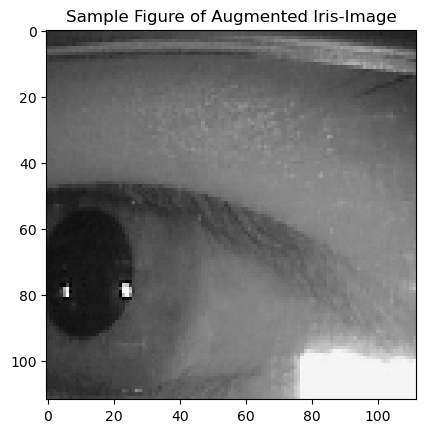

In [69]:
input_shape = (112, 112, 1)
data_augmentation = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Lambda(lambda x: tf.image.central_crop(x, central_fraction=0.5))
])

augmented_image = data_augmentation(x_train)
print(f'Person label is: {y_val[0]}')
plt.imshow(augmented_image[0], cmap='gray')
plt.title('Sample Figure of Augmented Iris-Image')
plt.show

In [165]:
## converting images to float32 and normalize it
#x_train = np.array(x_train, dtype = 'float32')/255.0
#x_val = np.array(x_val, dtype = 'float32')/255.0

In [226]:
#x_train, x_val

In [184]:
#y_train_flat = np.ravel(y_train)
#y_val_flat = np.ravel(y_val)

In [228]:
if len(y_train) != len(x_train):
    y_train = np.ravel(y_train)[:len(x_train)]
    y_val = np.ravel(y_val)[:len(x_val)]

In [230]:
# Apply label encoder
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val)

ValueError: y should be a 1d array, got an array of shape (74, 2) instead.

In [268]:
y_train.shape, y_val.shape

((74, 2), (9, 2))

In [270]:
x_train.shape, x_val.shape

((74, 224, 224), (9, 224, 224))

In [216]:
le

LabelEncoder()

In [218]:
## Apply One-Hot Encoding method

y_train=to_categorical(y_train_int)
y_val=to_categorical(y_val_int)

In [272]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

In [222]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((74, 224, 224), (74, 2), (9, 224, 224), (9, 2))

In [224]:
type(y_train[0]), y_train[0]

(numpy.ndarray, array([1., 0.]))

### Model Training

In [254]:
### Configuration

EPOCHS = 20
IMG_SIZE = (96, 96)
BATCH_SIZE = 4
loss = 'sparse_categorical_crossentropy'
classes = len(np.unique(y_train))
activation = 'leaky_relu'
initial_learning_rate = 0.002
optimizer = Adam(learning_rate=initial_learning_rate)

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='value_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [256]:
## We'll create the model

def build_model():
    
    padding = 'same'
    poolpadding = 'valid'

    ##model = keras.Sequential([
    model = keras.Sequential(name = 'Biometric-Iris-Recognition-Scanning.h5')
    model.add(layers.Input(shape=input_shape)),

    ## Conv-1
    model.add(Conv2D(32, (5, 5), padding=padding))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding=poolpadding))
    model.add(GaussianNoise(0.1))
    model.add(Dropout(0.1))

    ## Conv-2
    model.add(Conv2D(64, (5, 5), padding=padding))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2), padding=poolpadding))
    #model.add(Dropout(0.1))

    ## Conv-3
    model.add(Conv2D(128, (5, 5), padding=padding))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2), padding=poolpadding))
    #model.add(Dropout(0.25))
    

    ## Conv-4
    model.add(Conv2D(256, (3, 3), padding=padding))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2), padding=poolpadding))
    #model.add(Dropout(0.25))


    ##Conv-5
    model.add(Conv2D(256, (3, 3), padding=padding))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2), padding=poolpadding))
    #model.add(Dropout(0.25))
        
    ## Conv-6
    model.add(Conv2D(512, (3, 3), padding=padding))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2), padding=poolpadding))
    #model.add(Dropout(0.45))

    ## Conv-7
    model.add(Conv2D(512, (2, 2), padding=padding))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2), padding=poolpadding))
    #model.add(Dropout(0.5))
        
    ## Flatten Dense Layers
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128))
    model.add(layers.Activation(tf.nn.gelu))
    model.add(Dense(classes, activation='softmax'))

    ## Let's compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [258]:
model = build_model()
model.summary()

Model: "Biometric-Iris-Recognition-Scanning.h5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_59 (Conv2D)                   │ (None, 112, 112, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_59 (LeakyReLU)           │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_8 (GaussianNoise)     │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 56, 56, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_60 (LeakyReLU)           │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 56, 56, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_61 (LeakyReLU)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_62 (LeakyReLU)           │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_63 (LeakyReLU)           │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 56, 56, 512)         │       1,180,1

 Total params: 3,444,482 (13.14 MB)

 Trainable params: 3,440,962 (13.13 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [238]:
## model history

history = model.fit(
    x_train, y_train,
    validation_data = (x_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4781 - loss: 0.7193

C:\Users\OMDEEP\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `value_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss



19/19 ━━━━━━━━━━━━━━━━━━━━ 289s 8s/step - accuracy: 0.4752 - loss: 0.7197 - val_accuracy: 0.4444 - val_loss: 3.0014 - learning_rate: 0.0020
Epoch 2/20


C:\Users\OMDEEP\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning:

Learning rate reduction is conditioned on metric `value_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.



19/19 ━━━━━━━━━━━━━━━━━━━━ 149s 8s/step - accuracy: 0.4577 - loss: 0.7537 - val_accuracy: 0.5556 - val_loss: 0.7531 - learning_rate: 0.0020
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 150s 8s/step - accuracy: 0.4280 - loss: 0.7003 - val_accuracy: 0.5556 - val_loss: 2.3371 - learning_rate: 0.0020
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 153s 8s/step - accuracy: 0.3903 - loss: 0.7106 - val_accuracy: 0.5556 - val_loss: 1.9230 - learning_rate: 0.0020
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - accuracy: 0.4598 - loss: 0.6932 - val_accuracy: 0.5556 - val_loss: 1.1657 - learning_rate: 0.0020
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.4163 - loss: 0.6937 - val_accuracy: 0.4444 - val_loss: 2.0123 - learning_rate: 0.0020
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - accuracy: 0.6654 - loss: 0.6628 - val_accuracy: 0.4444 - val_loss: 3.2815 - learning_rate: 0.0020
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 145s 8s/step - accuracy: 0.4150 - loss: 0.7249 - val_accuracy: 0.55

In [248]:
model.save('Biometric-Iris-Recognition-Scanning.h5')

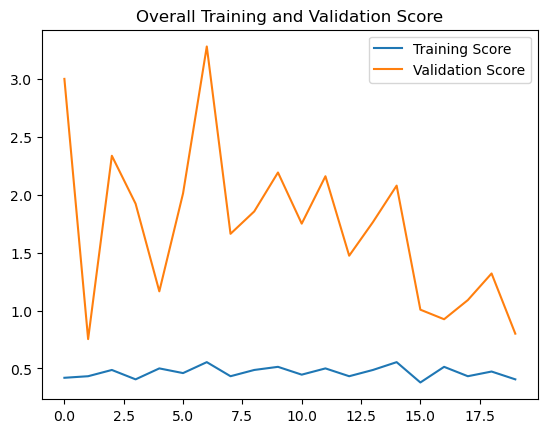

In [264]:
## Checking the overall 'Accuracy Score' 

plt.plot(history.history['accuracy'], label='Training Score')
plt.plot(history.history['val_loss'], label='Validation Score')
plt.title('Overall Training and Validation Score')
plt.legend()
plt.show()

In [276]:
## check the test scores
train_loss, train_acc = model.evaluate(x_train, y_train)
print(f'Testing Accuracy: {train_acc*100:.3f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 428s 72s/step - accuracy: 0.5000 - loss: 0.6931
Testing Accuracy: 50.000


In [278]:
## check for the validation accuarcy 
val_loss, val_acc = model.evaluate(x_val, y_val)
print(f'Validation Accuracy: {val_acc*100:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.4444 - loss: 0.6931
Validation Accuracy: 44.444


#### Set up the Configuration

In [ ]:
## configuration

image_size = (224, 224)
batch_size = 32
data_folder = r'E:\Iris Detection Model\Iris Model'
csv_file = r'E:\Iris Detection Model\Iris Model\iris_thousands.csv'

In [ ]:
df = pd.read_csv(csv_file)
df

In [ ]:
## Get information related to this iris images, labels 
df.info()    

In [ ]:
df.describe()

In [ ]:
# get the first five rows 
df.head()

In [ ]:
df.shape

In [ ]:
# count the number of labels as well as images
df.count()

In [ ]:
#df.value_counts().sum()

In [ ]:
## Check for null values
df.isnull().sum()

In [ ]:
missing_vals = df['Label'].isnull().sum()

In [ ]:
missing_vals

In [ ]:
unique_vals = df['Label'].unique()
unique_vals

In [ ]:
print(f'Number of Images: {len(df)}')
print(f'Number of Unique labels: {len(unique_vals)}')
print(f'Number of sample images: {unique_vals[:20]}')

In [ ]:
class_counts = df['Label'].value_counts()
class_counts

### Load the Class - 'Label' column for Images

In [ ]:
### Load the 'label' columns
class IrisDetectionPipeline:
    def __init__(self, image_size, batch_size, data_folder, csv_file):
        """
        Args:
        Dataset_folder as:- 'E:\Iris Detection Model\Iris Model'
        Start with:: Image size, Batch_size to be set it as 32
        """

        self.image_size = image_size
        self.batch_size = batch_size
        self.data_folder = data_folder
        self.csv_file = csv_file
        self.df = None
        self.model = None
        self.history = None
        self.label_encoder = LabelEncoder()

    def load_labels(self):
        """
        Find the number of value counts of images in Labels columns
        then we'll count the maximum and minimum number of image names
        """
        ## setting the csv_file path
        csv_path = os.path.join(self.data_folder, self.csv_file)
        self.df = pd.read_csv(csv_path)
        

        ## Load the number of images in Labels columns
        class_counts = self.df['Label'].value_counts()
        #print(f'Shape of the Label images: {class_counts.shape}')
        print(f'Maximum number of Images: {class_counts.max()}')
        print(f'Minimum number of Images: {class_counts.min()}')
        print(f'Length of Images: {len(class_counts)}')
        #print(f'Average number of Images: {class_counts.mean()}')

        return self.df

In [ ]:
## Initializing the model pipeline

print(f'Image_size: {image_size}')
print(f'Batch_size: {batch_size}')
print(f'Data_Folder: {data_folder}')
print(f'CSV_File: {csv_file}')

In [ ]:
#pipeline = IrisDetectionPipeline(
 #   224,
  #  32,
   # r'E:\Iris Detection Model\Iris Model',
    #'iris_thousands.csv'
    
#)
pipeline = IrisDetectionPipeline(image_size=image_size, batch_size=batch_size, data_folder=data_folder, csv_file=csv_file)

df = pipeline.load_labels()


## Let's do some Visualization

In [ ]:
class ImprovedIrisDetectionPipeline:
    """
    Improved Iris Detection Pipeline based on your current progress
    """
    
    def __init__(self, data_folder, csv_file, image_size=(224, 224), batch_size=32):
        """
        Initialize the pipeline with your current setup
        """
        self.data_folder = data_folder
        self.csv_file = csv_file
        self.image_size = image_size
        self.batch_size = batch_size
        self.model = None
        self.history = None
        self.df = None
        self.label_encoder = LabelEncoder()
        
        print("🚀 Iris Detection Pipeline Initialized")
        print(f"Data folder: {data_folder}")
        print(f"CSV file: {csv_file}")
        print(f"Image size: {image_size}")
        print(f"Batch size: {batch_size}")
    
    def load_and_verify_csv(self):
        """
        Load and verify your CSV file structure
        """
        print("\n📊 STEP 1: Loading and Verifying CSV Data")
        print("="*60)
        
        # Load CSV
        self.df = pd.read_csv(self.csv_file)
        
        print("✓ CSV loaded successfully!")
        print(f"✓ Dataset shape: {self.df.shape}")
        print(f"✓ Columns: {list(self.df.columns)}")
        
        # Display first few rows
        print(f"\nFirst 5 rows:")
        print(self.df.head())
        
        # Check for missing values
        missing_values = self.df.isnull().sum()
        print(f"\nMissing values:")
        print(missing_values)
        
        # Unique labels analysis
        unique_labels = self.df['Label'].unique()
        print(f"\nDataset Statistics:")
        print(f"✓ Total images: {len(self.df)}")
        print(f"✓ Unique classes: {len(unique_labels)}")
        print(f"✓ Sample labels: {unique_labels[:10]}")
        
        # Class distribution
        class_counts = self.df['Label'].value_counts()
        print(f"✓ Images per class (avg): {class_counts.mean():.1f}")
        print(f"✓ Min images per class: {class_counts.min()}")
        print(f"✓ Max images per class: {class_counts.max()}")
        
        return self.df
    
    def visualize_dataset_distribution(self):
        """
        Create comprehensive visualizations of your dataset
        """
        print("\n📈 STEP 2: Dataset Visualization")
        print("="*60)
        
        if self.df is None:
            print("❌ Please load the CSV first using `load_and_verify_csv()`!")
            return
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Class distribution histogram
        class_counts = self.df['Label'].value_counts()
        axes[0, 0].hist(class_counts.values, bins=20, edgecolor='black', alpha=0.7)
        axes[0, 0].set_title('Distribution of Images per Person')
        axes[0, 0].set_xlabel('Number of Images')
        axes[0, 0].set_ylabel('Number of Persons')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Top 20 classes
        top_classes = class_counts.head(20)
        axes[0, 1].bar(range(len(top_classes)), top_classes.values)
        axes[0, 1].set_title('Top 20 Classes by Image Count')
        axes[0, 1].set_xlabel('Class Index')
        axes[0, 1].set_ylabel('Number of Images')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Eye type distribution (L vs R)
        eye_types = self.df['Label'].str.extract(r'(\d+)-([LR])')[1].value_counts()
        axes[1, 0].pie(eye_types.values, labels=eye_types.index, autopct='%1.1f%%')
        axes[1, 0].set_title('Left vs Right Eye Distribution')
        
        # 4. Person ID distribution (sample)
        person_ids = self.df['Label'].str.extract(r'(\d+)-[LR]')[0].value_counts()
        axes[1, 1].hist(person_ids.values, bins=20, edgecolor='black', alpha=0.7)
        axes[1, 1].set_title('Images per Person ID')
        axes[1, 1].set_xlabel('Number of Images')
        axes[1, 1].set_ylabel('Number of Person IDs')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✓ Dataset visualization complete!")

In [ ]:
# 1. Set up paths
#csv_file = r"E:\Iris Detection Model\Iris Model\iris_thousands.csv"
#data_folder = r"E:\Iris Detection Model\Iris Model\CASIA-Iris-Thousand"

# 2. Create an instance of the class
pipeline = ImprovedIrisDetectionPipeline(data_folder=data_folder, csv_file=csv_file)

# 3. Call the method on the instance
df = pipeline.load_and_verify_csv()


In [ ]:

zip_path = r'E:\Iris Detection Model\Iris Model'
csv_name_in_zip = 'iris_thousands.csv'


In [ ]:
extract_path = r"E:\Iris Detection Model\archive_extracted"

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("ZIP extracted to:", extract_path)

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open(csv_name_in_zip) as csv_file:
        f = pd.read_csv(csv_file)

In [ ]:
df

#### Explore the dataset

In [ ]:
len(df)

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
df.count()

In [ ]:
df.value_counts

In [ ]:
missing_count = df.isnull().sum()
missing_count

In [ ]:
df['Label'].value_counts()

In [ ]:
df['Label'].count()

In [ ]:
df.nunique()

#### Let's start with the Image Visualization 

In [ ]:
def visualizing_image_samples(df, num_images):
    random.seed(1190652)
    random_indices = random.sample(range(df.shape[0]), num_images)
    num_rows = math.ceil(num_images / 4) 

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5))  
    for i, idx in enumerate(random_indices):
        row = i // 4
        col = i % 4
        
        if idx < df.shape[0]:  
            image_path =  df.loc[idx, "ImagePath"]
            image = PIL.Image.open(image_path)
            ax = axes[row, col] if num_rows > 1 else axes[col]
            ax.imshow(image, cmap='gray')
            ax.set_title(f"Image {idx} Person Label: {df.loc[idx, 'Label']}")
            ax.axis("off")

    plt.suptitle("Figure 3: Random Small Sample of the Dataset")
    plt.tight_layout()
    plt.show()

In [ ]:
local_base_path = r'E:\Iris Detection Model\archive (5).zip\CASIA-Iris-Thousand\CASIA-Iris-Thousand'
f["ImagePath"] = f["ImagePath"].apply(lambda path: os.path.join(local_base_path, *path.split("/")[-4:]))

In [ ]:
## load the dataset

visualizing_image_samples(df, 10)

In [ ]:
print(f"Total images in DataFrame: {len(df)}")
print(df.head())

In [ ]:
df['ImagePath'].head(10)

In [ ]:
df = load_dataset(r'E:\Iris Detection Model\archive_extracted\CASIA-Iris-Thousand')